In [2]:
import pandas as pd
import numpy as np
from glob import glob

from scipy import stats

from sklearn.metrics import roc_auc_score, average_precision_score

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
sns.set(style='ticks', context='notebook', font_scale=1.2)

In [3]:
def get_results(folder, cols):
    num_folds = len(glob(f'{folder}/predictions_*.csv'))
    df_y_test = pd.DataFrame(columns=cols + ['fold'])
    df_y_pred = pd.DataFrame(columns=cols + ['fold'])  
    for i in range(num_folds):
        y_test = pd.read_csv(f'{folder}/input_test_{i}.csv').loc[:, cols]
        y_pred = pd.read_csv(f'{folder}/predictions_{i}.csv').loc[:, cols]
        y_test.loc[:, 'fold'] = int(i)
        y_pred.loc[:, 'fold'] = int(i)
        df_y_test = df_y_test.append(y_test, ignore_index=True)
        df_y_pred = df_y_pred.append(y_pred, ignore_index=True)
    return df_y_test, df_y_pred


def get_performance(df_y_test, df_y_pred, average='micro', weighted_avg=False):
    cols = [c for c in df_y_test.columns if c != 'fold']
    kfolds = list(set(df_y_test.loc[:, 'fold']))

    rocs = []
    prcs = []
    weights = []

    for k in kfolds:
        mask = df_y_test.loc[:, 'fold'] == k
        y_test = df_y_test.loc[mask, cols].to_numpy().astype(int)
        y_pred = df_y_pred.loc[mask, cols].to_numpy()
        
        roc = roc_auc_score(y_test, y_pred, average=average)
        # average precision is the same as the area under the precision-recall curve
        prc = average_precision_score(y_test, y_pred, average=average)
        
        rocs.append(roc)
        prcs.append(prc)
        weights.append(len(y_test))

    if weighted_avg is True:
        rocs = np.array(rocs)
        prcs = np.array(prcs)
        weights = np.array(weights)

        roc_mean = np.average(rocs, weights=weights)
        prc_mean = np.average(prcs, weights=prcs)
        
        werr2 = (weights**2 * (rocs - roc_mean)**2 ).sum()
        roc_sem = np.sqrt(werr2) / np.sum(weights)

        werr2 = (weights**2 * (prcs - prc_mean)**2 ).sum()
        prc_sem = np.sqrt(werr2) / np.sum(weights)
    else:
        roc_mean = np.mean(rocs)
        roc_sem = stats.sem(rocs)
        prc_mean = np.mean(prcs)
        prc_sem = stats.sem(prcs)
    
    return rocs, prcs, roc_mean, roc_sem, prc_mean, prc_sem


def apply_alpha_to_boxplot(boxplot_obj, alpha=0.5):
    for patch in boxplot_obj.artists:   
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, alpha))


def apply_alpha_to_pointplot(pointplo_obj, alpha=0.5):
    plt.setp(pointplo_obj.collections, alpha=alpha) #for the markers
    plt.setp(pointplo_obj.lines, alpha=alpha)       #for the lines

## Plot MPNN results

cv10-stratified/master/
PRC = 0.47 +/- 0.01       ROC = 0.79 +/- 0.00

cv10-stratified/polymer-chain/
PRC = 0.49 +/- 0.01       ROC = 0.81 +/- 0.00

cv10-stratified/polymer-Xn/
PRC = 0.52 +/- 0.01       ROC = 0.79 +/- 0.01

cv10-stratified/polymer-stoich/
PRC = 0.67 +/- 0.01       ROC = 0.89 +/- 0.00

cv10-stratified/polymer-stoich-chain-Xn/
PRC = 0.68 +/- 0.01       ROC = 0.90 +/- 0.00



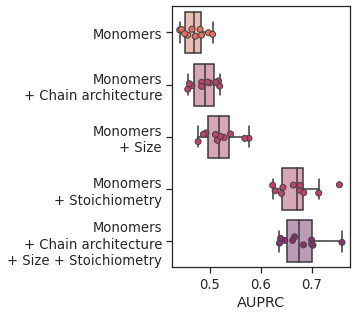

In [5]:
cols = ['lamellar','cylinder','sphere','gyroid','disordered']

# ------------
# collect data
# ------------
cv_split = 'cv10-stratified'

folders = [f'{cv_split}/master/', 
           f'{cv_split}/polymer-chain/',
           f'{cv_split}/polymer-Xn/',
           f'{cv_split}/polymer-stoich/',
           f'{cv_split}/polymer-stoich-chain-Xn/',
           ]

xticklabels = ['Monomers', 
               'Monomers\n+ Chain architecture', 
               'Monomers\n+ Size',
               'Monomers\n+ Stoichiometry',
               'Monomers\n+ Chain architecture\n+ Size + Stoichiometry']

average = 'macro'

df = pd.DataFrame(columns=['roc', 'prc', 'model'])
for i, folder in enumerate(folders):
    print(folder)
    df_y_test, df_y_pred = get_results(folder, cols)
    rocs, prcs, roc_mean, roc_sem, prc_mean, prc_sem = get_performance(df_y_test, df_y_pred, average=average)
    d = pd.DataFrame({'roc':rocs, 'prc':prcs, 'model':folder})
    df = df.append(d, ignore_index=True)
    print(f"PRC = {prc_mean:.2f} +/- {prc_sem:.2f}       ROC = {roc_mean:.2f} +/- {roc_sem:.2f}")
    print()
    

# ----
# plot
# ----
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4*0.8,6*0.8))
colors0 = sns.color_palette("flare", 3)
colors1 = sns.color_palette("crest", 2)
palette = [colors0[0], colors0[1], colors0[1], colors0[1], colors0[2]]

box = sns.boxplot(y="model", x="prc", data=df, ax=ax, palette=palette, showfliers=False)
strip = sns.stripplot(y="model", x="prc", data=df, ax=ax, dodge=True, alpha=1, zorder=10, 
                      size=6, edgecolor='#444444', linewidth=1, palette=palette)
apply_alpha_to_boxplot(box, 0.5)

# ------
# labels
# ------
ax.set_xlabel('AUPRC')
ax.set_ylabel('')

# ------
# legend
# ------
_ = ax.set_yticklabels(xticklabels, rotation=0)

## Plot results for MPNN and RF

cv10-stratified/master/
PRC = 0.47 +/- 0.01       ROC = 0.79 +/- 0.00

cv10-stratified/polymer-chain/
PRC = 0.49 +/- 0.01       ROC = 0.81 +/- 0.00

cv10-stratified/polymer-Xn/
PRC = 0.52 +/- 0.01       ROC = 0.79 +/- 0.01

cv10-stratified/polymer-stoich/
PRC = 0.67 +/- 0.01       ROC = 0.89 +/- 0.00

cv10-stratified/polymer-stoich-chain-Xn/
PRC = 0.68 +/- 0.01       ROC = 0.90 +/- 0.00

cv10-stratified/rf/w_val/Xn/
PRC = 0.68 +/- 0.01       ROC = 0.89 +/- 0.01

cv10-stratified/rf/w_val/N1/
PRC = 0.69 +/- 0.01       ROC = 0.90 +/- 0.00

cv10-stratified/rf/w_val/N1_Xn/
PRC = 0.71 +/- 0.01       ROC = 0.92 +/- 0.00

cv10-stratified/rf/w_val/fps_counts/
PRC = 0.44 +/- 0.01       ROC = 0.77 +/- 0.00

cv10-stratified/rf/w_val/fps_counts-chain/
PRC = 0.44 +/- 0.01       ROC = 0.77 +/- 0.00

cv10-stratified/rf/w_val/fps_counts-Xn/
PRC = 0.71 +/- 0.01       ROC = 0.91 +/- 0.00

cv10-stratified/rf/w_val/fps_counts-stoich/
PRC = 0.73 +/- 0.01       ROC = 0.92 +/- 0.00

cv10-stratified/rf/w_val/f

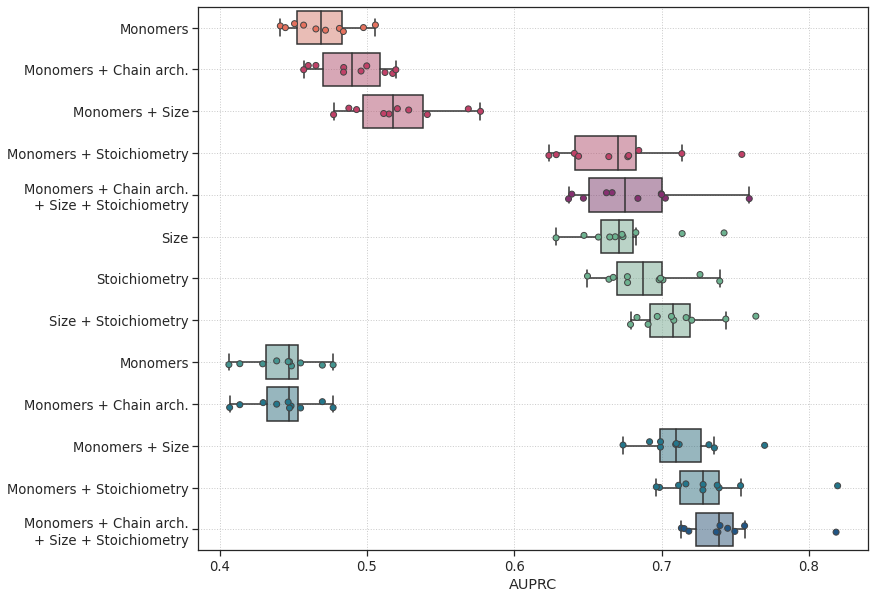

In [6]:
cols = ['lamellar','cylinder','sphere','gyroid','disordered']

# ------------
# collect data
# ------------
cv_split = 'cv10-stratified'
val = 'w_val'

folders = [# MPNN
           f'{cv_split}/master/', 
           f'{cv_split}/polymer-chain/',
           f'{cv_split}/polymer-Xn/',
           f'{cv_split}/polymer-stoich/',
           f'{cv_split}/polymer-stoich-chain-Xn/',
           # Random forest with only descriptors
           f'{cv_split}/rf/{val}/Xn/',
           f'{cv_split}/rf/{val}/N1/',
           f'{cv_split}/rf/{val}/N1_Xn/',
           # Random Forest
           f'{cv_split}/rf/{val}/fps_counts/', 
           f'{cv_split}/rf/{val}/fps_counts-chain/',
           f'{cv_split}/rf/{val}/fps_counts-Xn/',
           f'{cv_split}/rf/{val}/fps_counts-stoich/',
           f'{cv_split}/rf/{val}/fps_counts-chain_stoich_Xn/',
           ]

xticklabels = (['Monomers', 
               'Monomers + Chain arch.', 
               'Monomers + Size',
               'Monomers + Stoichiometry',
               'Monomers + Chain arch.\n+ Size + Stoichiometry'] + 
               ['Size', 'Stoichiometry', 'Size + Stoichiometry'] +
               ['Monomers', 
               'Monomers + Chain arch.', 
               'Monomers + Size',
               'Monomers + Stoichiometry',
               'Monomers + Chain arch.\n+ Size + Stoichiometry'])


average = 'macro'

df = pd.DataFrame(columns=['roc', 'prc', 'model'])
for i, folder in enumerate(folders):
    print(folder)
    df_y_test, df_y_pred = get_results(folder, cols)
    rocs, prcs, roc_mean, roc_sem, prc_mean, prc_sem = get_performance(df_y_test, df_y_pred, average=average)
    d = pd.DataFrame({'roc':rocs, 'prc':prcs, 'model':folder})
    df = df.append(d, ignore_index=True)
    print(f"PRC = {prc_mean:.2f} +/- {prc_sem:.2f}       ROC = {roc_mean:.2f} +/- {roc_sem:.2f}")
    print()
    

# ----
# plot
# ----
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 10))
colors0 = sns.color_palette("flare", 3)
colors1 = sns.color_palette("crest", 4)
palette = [colors0[0], colors0[1], colors0[1], colors0[1], colors0[2],
           colors1[0], colors1[0], colors1[0],
           colors1[1], colors1[2], colors1[2], colors1[2], colors1[3]
           ]

box = sns.boxplot(y="model", x="prc", data=df, ax=ax, palette=palette, showfliers=False)
strip = sns.stripplot(y="model", x="prc", data=df, ax=ax, dodge=True, alpha=1, zorder=10, 
                      size=6, edgecolor='#444444', linewidth=1, palette=palette)
apply_alpha_to_boxplot(box, 0.5)

# ------
# labels
# ------
ax.set_xlabel('AUPRC')
ax.set_ylabel('')
ax.grid(linestyle=':')

# ------
# legend
# ------
_ = ax.set_yticklabels(xticklabels, rotation=0)

In [7]:
# get results for a specific folder/input
folder = 'cv10-stratified/rf/w_val/f1'
df_y_test, df_y_pred = get_results(folder, cols)
rocs, prcs, roc_mean, roc_sem, prc_mean, prc_sem = get_performance(df_y_test, df_y_pred, average=average)
print(f"PRC = {prc_mean:.2f} +/- {prc_sem:.2f}       ROC = {roc_mean:.2f} +/- {roc_sem:.2f}")

PRC = 0.71 +/- 0.01       ROC = 0.90 +/- 0.00
